# **Project Pipeline**

| **Steps**                                              | **Script files**                          |
|-----------------------------------------------------------|-------------------------------------------|
| 1) Read and pre-process data                              | pre_processing.py                         |
| 2) Feature engineering                                    | feature_engineering.py                    |
| 3) Train models                                           | model_training.py, <br>tree_model_training.py |
| 4) Predict on test_features <br>and write submission file | final_predict.py                          |

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import scripts.pre_processing as pp
import scripts.feature_engineering as fe
import scripts.tree_model_training as tm
import scripts.linear_model_training as lm
from scripts.model_evaluation import regression_evaluation
import scripts.final_predict as fp

## 1) Pre-process data

In [2]:
# Read in data files 
train_features = pd.read_csv('./data/dengue_features_train.csv')
train_target = pd.read_csv('./data/dengue_labels_train.csv')
test_features = pd.read_csv('./data/dengue_features_test.csv')

In [3]:
# Merge features and target data
data = pp.merge_data(train_features, train_target, test_features, inc_test=False)

# Run processing and split by city
train_iq = pp.pre_process(data, 'iq', remove_anomalies=True, inc_test=False)
train_sj = pp.pre_process(data, 'sj', remove_anomalies=True, inc_test=False)

# Run checks for missing values
assert train_iq.isnull().any().any() == False
assert train_sj.isnull().any().any() == False
Xy_iq = train_iq.copy()
Xy_sj = train_sj.copy()
print(f'train_iq shape: {Xy_iq.shape}') 
print(f'train_sj shape: {Xy_sj.shape}') 

train_iq shape: (468, 24)
train_sj shape: (928, 24)


## 2) Feature engineering

In [4]:
# Run feature engineering 
Xy_iq = fe.cyclical_encode_date(Xy_iq)
Xy_sj = fe.cyclical_encode_date(Xy_sj)
#Xy_iq = fe.shift_features(Xy_iq, periods=1)
#Xy_sj = fe.shift_features(Xy_sj, periods=1)
Xy_iq = fe.drop_date(Xy_iq)
Xy_sj = fe.drop_date(Xy_sj)
Xy_iq = fe.add_rolling(Xy_iq, 'iq', fillna=True)
Xy_sj = fe.add_rolling(Xy_sj, 'sj', fillna=True)
Xy_iq = fe.remove_original_cols(Xy_iq)
Xy_sj = fe.remove_original_cols(Xy_sj)
print(f'train_iq shape: {Xy_iq.shape}') 
print(f'train_sj shape: {Xy_sj.shape}') 

train_iq shape: (468, 27)
train_sj shape: (928, 27)


Text(0.5, 1.0, 'San Juan Variable Correlations')

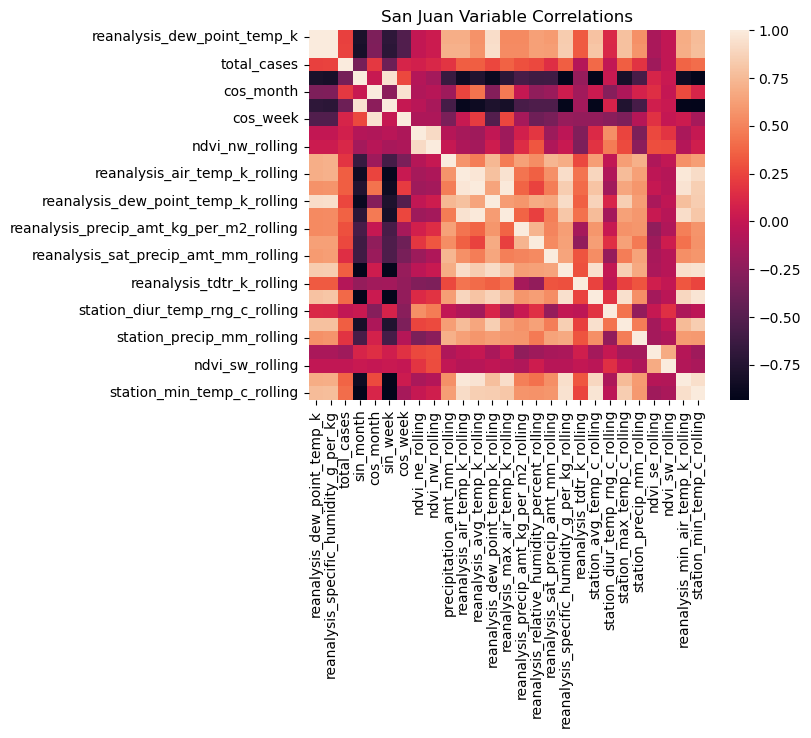

In [5]:
sj_corr_heat = sns.heatmap(Xy_sj.corr())
plt.title('San Juan Variable Correlations')


In [6]:
#(Xy_sj.total_cases
#   .drop('total_cases', axis=1) # don't compare with myself
#   .sort_values(ascending=False)
#   .plot
#   .barh())

In [7]:
# Split data into X and y
X_iq = Xy_iq.drop(labels=['total_cases'], axis=1)
y_iq = Xy_iq['total_cases']
X_sj = Xy_sj.drop(labels=['total_cases'], axis=1)
y_sj = Xy_sj['total_cases']
assert len(X_iq) == len(y_iq)

## 3) Train models

### Baseline model

In [8]:
# Baseline model predictions for Iquitos (Iq)
bl_pred_train = np.tile(np.mean(y_iq), len(y_iq))
bl_pred_test = np.tile(np.mean(y_iq), len(y_iq))
print('For Iquitos: ')
regression_evaluation(y_iq, y_iq, bl_pred_train, bl_pred_test)

# Baseline model predictions for San Jose (sj)
bl_pred_train = np.tile(np.mean(y_sj), len(y_sj))
bl_pred_test = np.tile(np.mean(y_sj), len(y_sj))
print('For San Jose: ')
regression_evaluation(y_sj, y_sj, bl_pred_train, bl_pred_test)

For Iquitos: 

    Evaluation metrics:
        RMSE train: 9.229210061419424
        RMSE test: 9.229210061419424
        MAE train: 6.3654028782233905
        MAE test: 6.3654028782233905 
    
For San Jose: 

    Evaluation metrics:
        RMSE train: 39.06484683794444
        RMSE test: 39.06484683794444
        MAE train: 24.198600995838284
        MAE test: 24.198600995838284 
    


(39.06484683794444, 39.06484683794444, 24.198600995838284, 24.198600995838284)

### Poisson regression model

In [9]:
# Poisson regression model for iq
X, y = X_iq, y_iq
lm.poisson_reg_model(X, y)

/opt/homebrew/Caskroom/miniforge/base/envs/DSR-comp/lib/python3.10/site-packages/sklearn/linear_model/_glm/glm.py:284: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/homebrew/Caskroom/miniforge/base/envs/DSR-comp/lib/python3.10/site-packages/sklearn/linear_model/_glm/glm.py:284: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/homebrew/Caskroom/miniforge/base/envs/DSR-comp/lib/python3.10/site-packages/sklearn/linear_model/_glm/glm.py:284: ConvergenceWarning: lbfgs failed to converg

,TSS iteration,rmse_test,rmse_train,mae_test,mae_train,alpha,mat_iter
0,1,8.938467,5.359893,5.874819,3.832630,0.6,100
1,1,8.826883,5.250066,5.773883,3.779609,0.6,200
2,1,8.760916,5.513692,5.652540,3.907384,1.0,100
3,1,8.747166,5.324607,5.673370,3.837587,1.0,200
4,2,12.133740,6.491990,8.273421,4.574039,0.6,100
5,2,12.415610,6.182381,8.872322,4.371007,0.6,200
6,2,12.174544,6.469647,8.125967,4.578333,1.0,100
7,2,12.294582,6.231027,8.577227,4.417911,1.0,200


In [10]:
# Poisson regression model for sj
X, y = X_sj, y_sj
lm.poisson_reg_model(X, y)

/opt/homebrew/Caskroom/miniforge/base/envs/DSR-comp/lib/python3.10/site-packages/sklearn/linear_model/_glm/glm.py:284: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/homebrew/Caskroom/miniforge/base/envs/DSR-comp/lib/python3.10/site-packages/sklearn/linear_model/_glm/glm.py:284: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/homebrew/Caskroom/miniforge/base/envs/DSR-comp/lib/python3.10/site-packages/sklearn/linear_model/_glm/glm.py:284: ConvergenceWarning: lbfgs failed to converg

,TSS iteration,rmse_test,rmse_train,mae_test,mae_train,alpha,mat_iter
0,1,51.130250,29.445393,31.130164,18.004038,0.6,100
1,1,89.566784,21.167508,58.997599,14.201232,0.6,200
2,1,51.823455,28.999308,30.994504,18.004820,1.0,100
3,1,80.773448,21.684922,52.829249,14.702659,1.0,200
4,2,33.761226,36.595796,26.325925,21.518091,0.6,100
5,2,31.756631,35.229475,24.115375,20.940301,0.6,200
6,2,32.238082,36.001908,24.440223,21.016584,1.0,100
7,2,31.443310,35.664492,24.139821,21.086359,1.0,200


<Axes: >

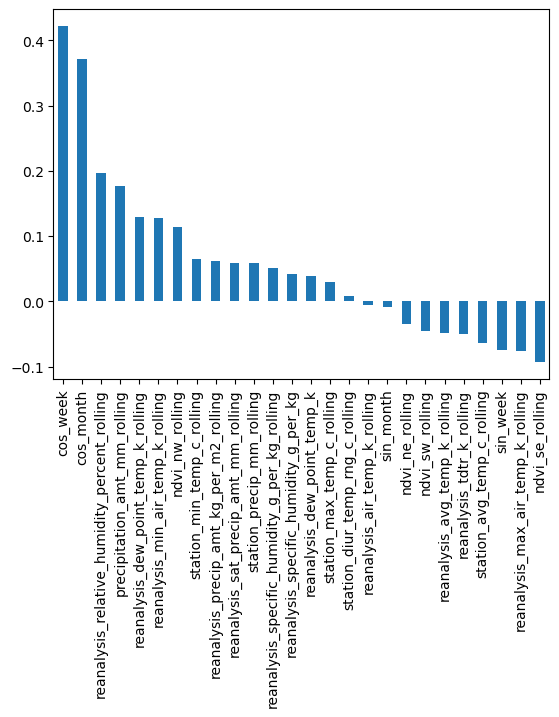

In [11]:
# Poisson get parameters for iq 
X, y = X_iq, y_iq
coefs = lm.poisson_get_coefs(X, y)
coefs.sort_values(ascending=False).plot.bar()

<Axes: >

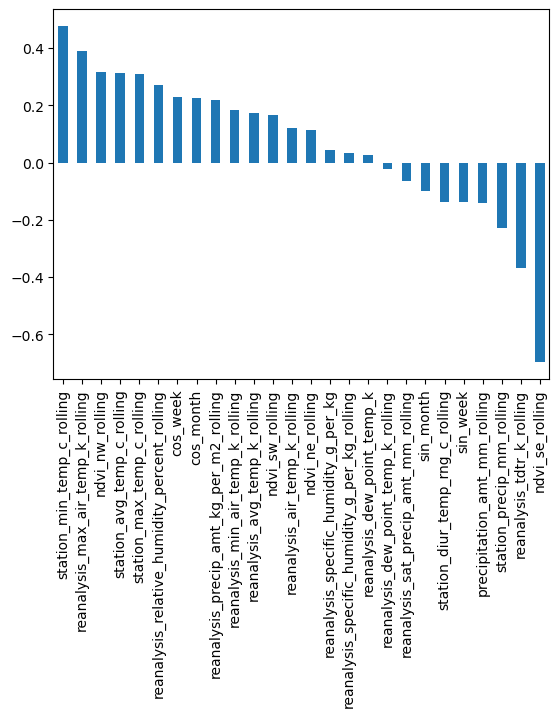

In [12]:
# Poisson get parameters for sj 
X, y = X_sj, y_sj
coefs = lm.poisson_get_coefs(X, y)
coefs.sort_values(ascending=False).plot.bar()

### Random forest model

In [13]:
# Random forest model for iq
X, y = X_iq, y_iq
tm.rforest_model(X, y)

,TSS iteration,rmse_test,rmse_train,mae_test,mae_train,n_estimators,max_depth,min_samples_split,min_samples_leaf
0,1,7.713637,3.512603,4.983739,2.536284,100,4,2,2
1,1,7.766697,3.634182,5.156647,2.602584,100,4,5,2
2,1,7.780024,2.334672,5.209345,1.551573,100,8,2,2
3,1,7.710713,2.462650,5.126080,1.645553,100,8,5,2
4,1,7.769634,3.349922,5.127786,2.431772,200,4,2,2
5,1,7.837604,3.470618,5.200550,2.511124,200,4,5,2
6,1,7.905334,2.307043,5.295753,1.561196,200,8,2,2
7,1,7.734124,2.588944,5.175325,1.719626,200,8,5,2
8,2,11.635475,4.834046,7.278677,3.426924,100,4,2,2
9,2,11.553186,4.849303,7.268124,3.390612,100,4,5,2


<Axes: >

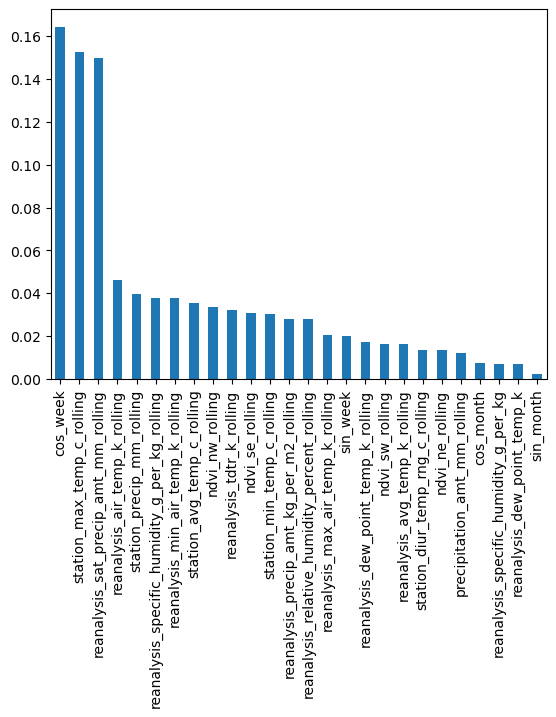

In [14]:
# Random forest feature importance for iq
X, y = X_iq, y_iq
feature_importances = tm.rf_feature_importance(X, y)
feature_importances.sort_values(ascending=False).plot.bar()

<Axes: >

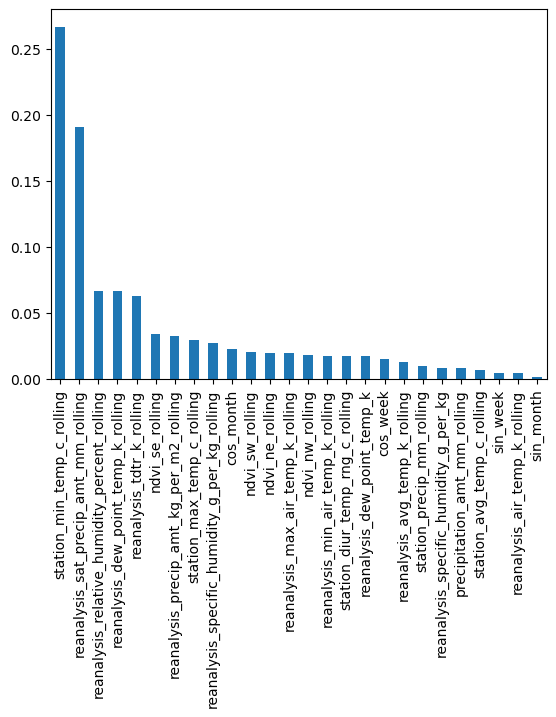

In [15]:
# Random forest feature importance for sj
X, y = X_sj, y_sj
feature_importances = tm.rf_feature_importance(X, y)
feature_importances.sort_values(ascending=False).plot.bar()

### XGBoost model

In [16]:
# XG boost model for iq
X, y = X_iq, y_iq
tm.xg_model(X, y)

,TSS iteration,rmse_test,rmse_train,mae_test,mae_train,learning_rate,n_estimators,max_depth,subsample,colsample_bytree,reg_lambda,gamma
0,1,8.347015,2.498056,5.504267,1.455590,0.05,100,5,0.6,0.8,10,10
1,2,12.360881,2.759211,7.484426,1.693765,0.05,100,5,0.6,0.8,10,10


In [17]:
# XG boost model for sj
X, y = X_sj, y_sj
tm.xg_model(X, y)

,TSS iteration,rmse_test,rmse_train,mae_test,mae_train,learning_rate,n_estimators,max_depth,subsample,colsample_bytree,reg_lambda,gamma
0,1,43.610162,12.743448,25.375340,4.565219,0.05,100,5,0.6,0.8,10,10
1,2,28.627090,12.996532,23.154191,6.107868,0.05,100,5,0.6,0.8,10,10


## 4) Predict on test data with chosen model and write file

Repeat the above transforms on the test set

In [18]:
# Code to run pipeline on dataset including test_features, and then take only test_features to run the final model
# Merge features and target data
data = pp.merge_data(train_features, train_target, test_features, inc_test=True)

# Run processing and split by city
Xy_iq_comb = pp.pre_process(data, 'iq', remove_anomalies=True, inc_test=True)
Xy_sj_comb = pp.pre_process(data, 'sj', remove_anomalies=True, inc_test=True)
assert Xy_iq_comb.isnull().any().any() == False
assert Xy_sj_comb.isnull().any().any() == False

# Run feature engineering 
Xy_iq_comb = fe.cyclical_encode_date(Xy_iq_comb)
Xy_sj_comb = fe.cyclical_encode_date(Xy_sj_comb)
#Xy_iq_comb = fe.shift_features(Xy_iq_comb, periods=1)
#Xy_sj_comb = fe.shift_features(Xy_sj_comb, periods=1)
Xy_iq_comb = fe.drop_date(Xy_iq_comb)
Xy_sj_comb = fe.drop_date(Xy_sj_comb)
Xy_iq_comb = fe.add_rolling(Xy_iq_comb, 'iq', fillna=True)
Xy_sj_comb = fe.add_rolling(Xy_sj_comb, 'sj', fillna=True)
Xy_iq_comb = fe.remove_original_cols(Xy_iq_comb)
Xy_sj_comb = fe.remove_original_cols(Xy_sj_comb)
print(f'Xy_iq_comb shape: {Xy_iq_comb.shape}') 
print(f'Xy_sj_comb shape: {Xy_sj_comb.shape}') 

# Split data into X and y
X_iq_comb = Xy_iq_comb.drop(labels=['total_cases'], axis=1)
y_train_iq = Xy_iq_comb.loc[Xy_iq_comb['total_cases'] >= 0, Xy_iq_comb.columns == 'total_cases']
y_test_iq = Xy_iq_comb.loc[Xy_iq_comb['total_cases'] < 0, Xy_iq_comb.columns == 'total_cases']
X_sj_comb = Xy_sj_comb.drop(labels=['total_cases'], axis=1)
y_train_sj = Xy_sj_comb.loc[Xy_sj_comb['total_cases'] >= 0, Xy_sj_comb.columns == 'total_cases']
y_test_sj = Xy_sj_comb.loc[Xy_sj_comb['total_cases'] < 0, Xy_sj_comb.columns == 'total_cases']

# Take now only the test features 
X_train_iq = X_iq_comb.iloc[:(X_iq_comb.shape[0] - y_test_iq.shape[0]) , :]
X_train_sj = X_sj_comb.iloc[:(X_sj_comb.shape[0] - y_test_sj.shape[0]) , :]
X_test_iq = X_iq_comb.iloc[(X_iq_comb.shape[0] - y_test_iq.shape[0]): , :]
X_test_sj = X_sj_comb.iloc[(X_sj_comb.shape[0] - y_test_sj.shape[0]): , :]

print(X_train_iq.shape, y_train_iq.shape)
print(X_train_sj.shape, y_train_sj.shape)
assert (X_train_iq.shape[0] == y_train_iq.shape[0])
assert (X_train_sj.shape[0] == y_train_sj.shape[0])


Xy_iq_comb shape: (624, 27)
Xy_sj_comb shape: (1188, 27)
(468, 26) (468, 1)
(928, 26) (928, 1)


In [19]:
# Select data and chosen model and hyperparameters for final prediction

params = dict(learning_rate=0.05,
        n_estimators=100,
        max_depth=5,
        subsample=0.6,
        colsample_bytree=0.8,
        reg_lambda=10,
        gamma=10)
 
# Iquitos, iq
X_test_iq = X_test_iq
X_train_iq = X_train_iq
y_train_iq = y_train_iq
model_iq = 'XGBRegressor'
params_iq = params

# San Jose, sj
X_test_sj = X_test_sj
X_train_sj = X_train_sj
y_train_sj = y_train_sj
model_sj = 'XGBRegressor'
params_sj = params


In [20]:
# Do final prediction and create final DataFrame for submission 
iq_preds = fp.final_predict(X_test_iq, X_train_iq, y_train_iq, city='iq', model=model_iq, params=params_iq)
sj_preds = fp.final_predict(X_test_sj, X_train_sj, y_train_sj, city='sj', model=model_sj, params=params_sj)
final_iq = test_features.loc[test_features.city == 'iq', ['city','year','weekofyear']]
final_sj = test_features.loc[test_features.city == 'sj', ['city','year','weekofyear']]

assert len(iq_preds) == final_iq.shape[0]
assert len(sj_preds) == final_sj.shape[0]

final_iq['total_cases'] = iq_preds.tolist()
final_sj['total_cases'] = sj_preds.tolist()
final = pd.concat([final_sj, final_iq], axis=0)
final['total_cases'] = final['total_cases'].astype(int)

assert final.isnull().any().any() == False
assert final.shape[0] == 416


In [23]:
preds_train_iq, y_train_iq = fp.preds_for_plot(X_test_iq, X_train_iq, y_train_iq, model=model_iq, params=params_iq)
preds_train_sj, y_train_sj = fp.preds_for_plot(X_test_sj, X_train_sj, y_train_sj, model=model_sj, params=params_sj)

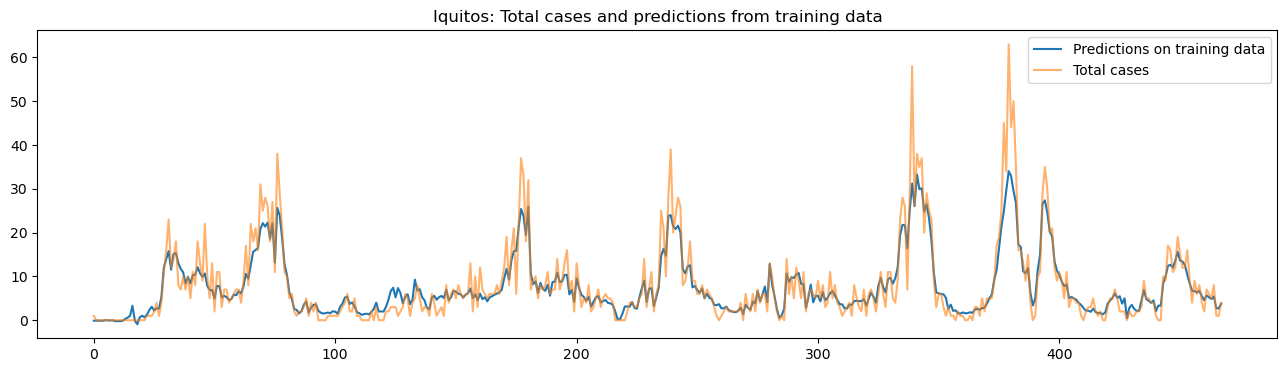

In [41]:
plt.figure(figsize=(16,4))
x = np.arange(468)
plt.plot(x, preds_train_iq, label='Predictions on training data')
plt.plot(x, y_train_iq, label='Total cases', alpha=0.6)
plt.title('Iquitos: Total cases and predictions from training data')
plt.legend();

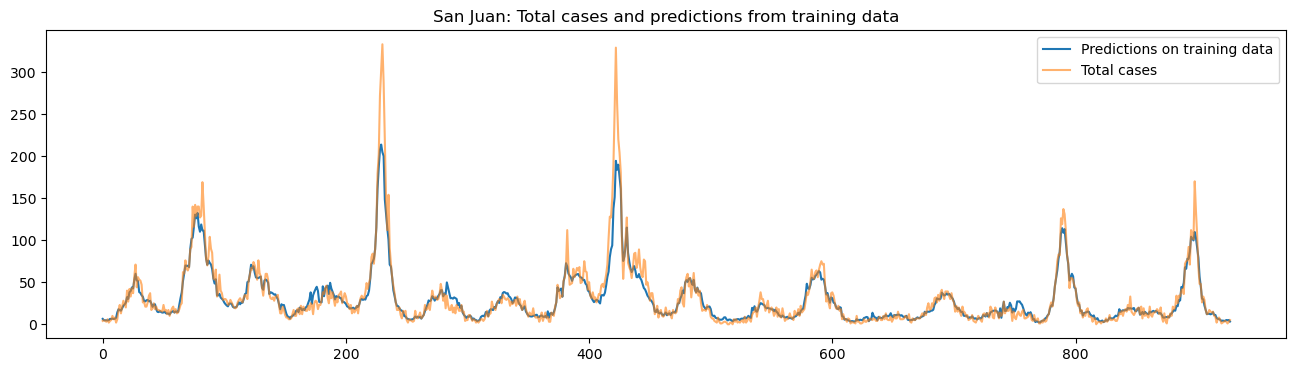

In [39]:
plt.figure(figsize=(16,4))
x = np.arange(928)
plt.plot(x, preds_train_sj, label='Predictions on training data')
plt.plot(x, y_train_sj, label='Total cases', alpha=0.6)
plt.title('San Juan: Total cases and predictions from training data')
plt.legend();

In [ ]:
# Write to file for submission 
print('Writing submission file to folder: ')
final.to_csv('for_submission_XGB_no_shift.csv', index=False)